# Overview

This notebook demonstrates how to evaluate a pre-trained neural network estimator on new, unseen trajectories. We'll generate custom drone trajectories over novel terrain, compute the corresponding optic flow, and assess how well the ANN generalizes to out-of-distribution data.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Load Pre-trained Model** - Import the trained ANN and SVD compressors
3. **Generate Novel Test Trajectory** - Create new drone trajectory and terrain
4. **Prepare Data for ANN** - Format trajectory data for model input
5. **Evaluate ANN Performance** - Apply model and visualize results
6. **Exercises** - Explore further improvements and integration

**Key learning objectives:**
- Understand how to evaluate neural network generalization
- Learn to generate custom test cases for model validation
- Assess estimator performance on out-of-distribution data
- Visualize and interpret estimation errors
- Identify failure modes and limitations of learned models

# 1.&nbsp;Install and Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

  Preparing metadata (setup.py) ... done
✓ nonlinear_estimation_utilities installed
✓ You have the latest version (0.0.35)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()
nonlinear_estimation_utilities.install_and_download_requirements.install_neural_network_requirements()

Attempting to pip install: casadi
Attempting to pip install: do_mpc
Attempting to pip install: git+https://github.com/vanbreugel-lab/pybounds
Attempting to pip install: pynumdiff
Already installed: tensorflow
Already installed: keras
Attempting to pip install: keras-visualizer
✓ pynumdiff 0.2 meets requirement >=0.1.4
Already installed: pynumdiff


## Install modules

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_neural_network_modules()

## Import modules

In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
import keras
import tensorflow as tf

In [7]:
import pybounds

In [8]:
from nonlinear_estimation_utilities import plot_utility
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility
from nonlinear_estimation_utilities import keras_ann_utility
from nonlinear_estimation_utilities import keras_advanced_utility

from nonlinear_estimation_utilities.plot_utility import plot_tme

# 2.&nbsp;Load Pre-trained Model

We'll load the neural network model that was trained in the previous notebook, along with the SVD compression matrices needed to transform the data into the reduced-order space.

## Load the trained ANN model

Load the model architecture and trained weights.

In [9]:
model_weights = 'ray_estimator.weights.h5'
model_config = 'ray_estimator.config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

ray_estimator_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('ray_estimator')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/ray_estimator.weights.h5
Successfully downloaded ray_estimator.weights.h5 (139408 bytes)
Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/ray_estimator.config.json
Successfully downloaded ray_estimator.config.json (584 bytes)
✓ Loaded configuration from: ray_estimator.config.json
✓ Model compiled with learning_rate=0.001
Loading weights from: ray_estimator.weights.h5
  ✓ Loaded: core_dense_0
  ✓ Loaded: aux_dense_0
  ✓ Loaded: core_dense_1
  ✓ Loaded: aux_dense_1
  ✓ Loaded: combined_dense_0
  ✓ Loaded: combined_dense_1

✓ Loaded 6 layers from: ray_estimator.weights.h5

✓ Model loaded successfully!
  Core input dim: 5
  Aux input dim: 115


## Create fast inference model

Convert the training model to an optimized inference model by removing dropout and other training-specific layers.

In [10]:
ray_estimator_inference_model = keras_advanced_utility.create_fast_inference_model(ray_estimator_model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


## Load SVD compressor matrices

Load the $U_r$ matrices for optic flow and ray distance compression that were computed during training. These are essential for transforming measurements into and out of the reduced-order space.

In [11]:
Ur_optic_flow_file = 'SVD_Ur_optic_flow.hdf'
Ur_ray_distance_file = 'SVD_Ur_ray_distance.hdf'

# If the model isn't here, download the pretrained model
for path in [Ur_optic_flow_file, Ur_ray_distance_file]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

Ur_optic_flow = pd.read_hdf(Ur_optic_flow_file).values
Ur_ray_distance = pd.read_hdf(Ur_ray_distance_file).values

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/SVD_Ur_optic_flow.hdf
Successfully downloaded SVD_Ur_optic_flow.hdf (24032 bytes)
Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/SVD_Ur_ray_distance.hdf
Successfully downloaded SVD_Ur_ray_distance.hdf (24112 bytes)


# 3.&nbsp;Generate Novel Test Trajectory

To evaluate how well the ANN generalizes, we'll create a completely new trajectory over novel terrain. This section is adapted from the trajectory generation notebook, allowing you to customize the test case.

**Goal:** Create a trajectory that differs from the training data to test the limits of the estimator's generalization capability.

## Create a new trajectory

First, set up the drone dynamics and measurement models.

In [12]:
# Planar drone dynamics and measurements
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

# Time step
dt = 0.1

# Set up the simulator
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
input_names = ['j1', 'j2']
measurement_names = h(None, None, return_measurement_names=True)

simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


### Define novel setpoints

<mark>This is the part you should change</mark> to make the trajectory do something new and interesting. Note that the path will still be limited by the drone's dynamics - the MPC controller will handle feasibility constraints automatically.

In [13]:
# First define the set-point(s) to follow
tsim = np.arange(0, 10.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 3*np.cos(2*np.pi*tsim*0.2),  # <<<< Do something interesting here
            'x_dot': NA,
            'z': 3*np.sin(2*np.pi*tsim*0.2)+0.5, # <<<<<< Do something interesting here
            'z_dot': NA,
           }

### Run the MPC controller

Execute the MPC to generate a dynamically feasible trajectory that follows the setpoints. This section needs no adjustment.

In [14]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

# Set some bounds
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0
simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

### Package results into trajectory dataframe

Repackage the simulation results into the standard trajectory dataframe format. This section needs no adjustment.

In [16]:
test_trajec = planar_drone.package_data_as_pandas_dataframe(t_sim, x_sim, u_sim, y_sim)

## Create a new terrain profile

<mark>Replace the terrain with something completely different from the training set.</mark>

**Hint:** You can get a sense of the training set terrain by visualizing terrain objects with different random seeds. Choose parameters that create notably different elevation profiles.

In [17]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=1)

# terrain.terrain defines the elevation profile, you can change in this in place.
# If you do, then you need to run this function so that subsequent functions that use the terrain object have the up-to-date profile.
terrain.__update_curve_points__()

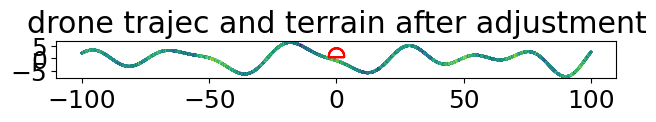

In [18]:
# adjust trajectory height
test_trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(test_trajec, terrain, plot=True)

## Calculate optic flow for the trajectory

Use the terrain and trajectory to compute the corresponding optic flow time series, then visualize it to verify the data looks reasonable.

In [19]:
result = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(test_trajec_adj, terrain)
imgs, analytic_optic_flows, ray_distances = result

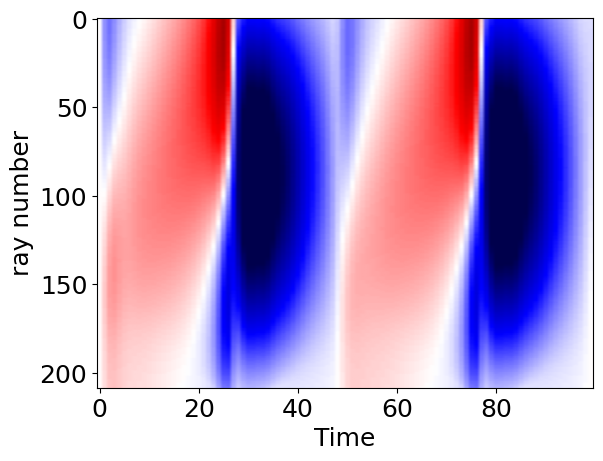

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(analytic_optic_flows, vmin=-3, vmax=3, cmap='seismic')
ax.set_ylabel('ray number')
ax.set_xlabel('Time')

ax.set_aspect('auto')

# 4.&nbsp;Prepare Data for ANN

Transform the trajectory data into the format required by the neural network. This includes SVD compression and delay embedding to create the time-windowed input features.

## Define helper function

This function encapsulates the data preparation steps from the training notebook, making it easy to prepare new trajectories for evaluation.

In [22]:
def prepare_trajectory_for_ANN(trajec, optic_flow, ray_distance, Ur_optic_flow, Ur_ray_distance):

    # Make robust to taking either a np array or pandas dataframe
    try:
        optic_flow = optic_flow.values
    except:
        pass

    try:
        ray_distance = ray_distance.values
    except:
        pass

    # Compress and rename columns for optic flow
    optic_flow_compressed = Ur_optic_flow.T@optic_flow
    optic_flow_compressed = pd.DataFrame(optic_flow_compressed.T)

    original_column_names = optic_flow_compressed.keys()
    optic_flow_column_names = ['sensor_optic_flow_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, optic_flow_column_names))
    optic_flow_compressed = optic_flow_compressed.rename(columns=col_name_replacement)

    # Compress and rename columns for ray distances
    ray_distance_compressed = Ur_ray_distance.T@ray_distance
    ray_distance_compressed = pd.DataFrame(ray_distance_compressed.T)

    original_column_names = ray_distance_compressed.keys()
    ray_distance_column_names = ['ray_distance_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, ray_distance_column_names))
    ray_distance_compressed = ray_distance_compressed.rename(columns=col_name_replacement)


    # Merge
    df = pd.concat([trajec.reset_index(),
                    optic_flow_compressed.reset_index(),
                    ray_distance_compressed.reset_index()],
                    axis=1)
    df = df.drop(len(df)-1) # drop last row since it has nans

    # This stuff should all probably be in some config file...##########
    trim_edges = 5

    output_names = ray_distance_column_names

    optic_flow_input_names = optic_flow_compressed.keys().tolist()
    other_input_names =  ['sensor_accel_x', 'sensor_accel_z']
    input_names = other_input_names + optic_flow_input_names

    time_window = 10
    input_offsets = np.arange(time_window)*-1
    output_offsets = [0]

    n_input = len(input_names) * time_window
    n_output = len(output_names)
    ######################################################################

    traj_augment = keras_ann_utility.collect_offset_rows(df[trim_edges:-1*trim_edges],
                                                       states=input_names,
                                                       controls=None,
                                                       outputs=output_names,
                                                       state_offsets=input_offsets,
                                                       control_offsets=None,
                                                       output_offsets=output_offsets)

    # Input data
    X = traj_augment.iloc[:, 0:n_input]

    # Output data
    Y = traj_augment.iloc[:, n_input:]

    return df, traj_augment, X, Y

## Prepare the trajectory

Apply the helper function to create compressed, delay-embedded inputs suitable for the ANN.

In [23]:
traj_combined_test, traj_timedelay_test, X_test, Y_test = prepare_trajectory_for_ANN(test_trajec_adj,
                                                                                     analytic_optic_flows,
                                                                                     ray_distances,
                                                                                     Ur_optic_flow,
                                                                                     Ur_ray_distance)

# 5.&nbsp;Evaluate ANN Performance

Apply the trained neural network to estimate ray distances for the new trajectory, then compare the estimates to ground truth to assess generalization performance.

## Apply the ANN to get ray distance estimates

Pass the prepared inputs through the neural network to obtain compressed ray distance estimates.

In [25]:
ray_estimate_compressed = ray_estimator_inference_model(tf.constant(X_test.values[:, 0:5]), # core data
                                                        tf.constant(X_test.values[:, 5:]))  # aux data

## Reconstruct full-dimensional estimates

Reproject the low-dimensional compressed estimates back into the original high-dimensional ray distance space using the SVD basis.

In [26]:
ray_estimate_compressed = np.array(ray_estimate_compressed)
ray_estimate = Ur_ray_distance@ray_estimate_compressed.T

## Verify data dimensions

Check the shapes to ensure the dimensions match up correctly for comparison.

In [27]:
ray_estimate.shape

(210, 80)

In [28]:
ray_distances.shape

(210, 100)

## Trim edges for fair comparison

Remove the first and last few time points where delay embedding creates boundary effects, ensuring a fair comparison between estimates and ground truth.

In [29]:
trim_edges = 5
time_window = 10

ray_true = ray_distances[:,time_window+trim_edges:-1*trim_edges]
ray_true.shape

(210, 80)

## Visualize ray distance estimates

Plot heatmaps comparing the estimated and true ray distances over time. This provides a comprehensive view of estimation quality across all rays and time steps.

Text(0, 0.5, 'Ray number')

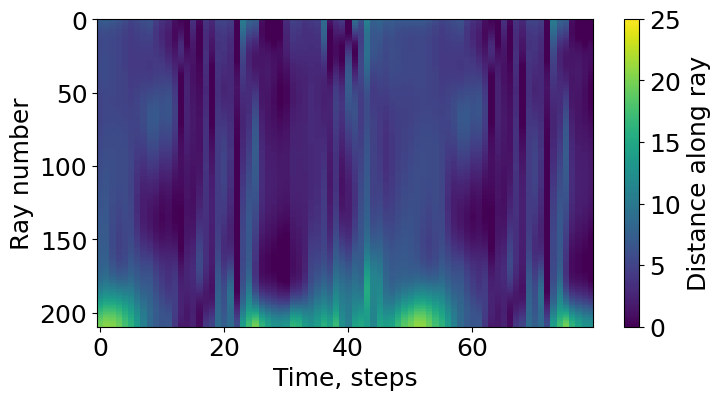

In [30]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_estimate, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

Text(0, 0.5, 'Ray number')

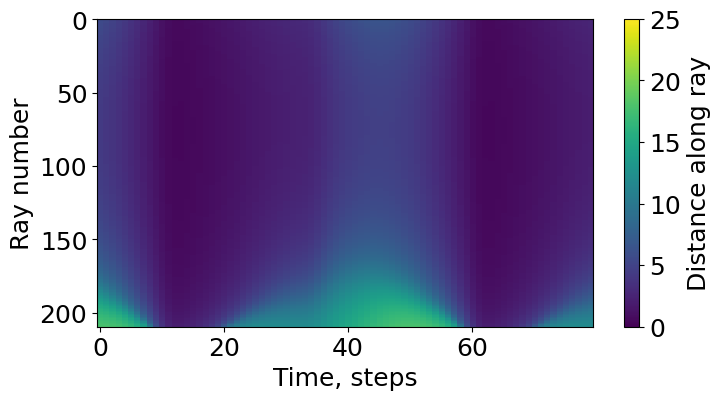

In [31]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_true, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

## Ventral altitude comparison

The center ray corresponds to the ventral (directly downward) altitude measurement. We can compare:
- **ANN estimates** (red) - Neural network predictions
- **True ray distances** (black dashed) - Ground truth measurements
- **Low-rank SVD approximation** (blue dots) - Best possible reconstruction with the chosen rank

This comparison helps separate errors due to:
1. Information loss from SVD compression (gap between black and blue)
2. Neural network estimation error (gap between blue and red)

In [32]:
# low rank approximation of the ray estimates
ray_true_compressed_recon = Ur_ray_distance@(Ur_ray_distance.T@ray_true)

(0.0, 30.0)

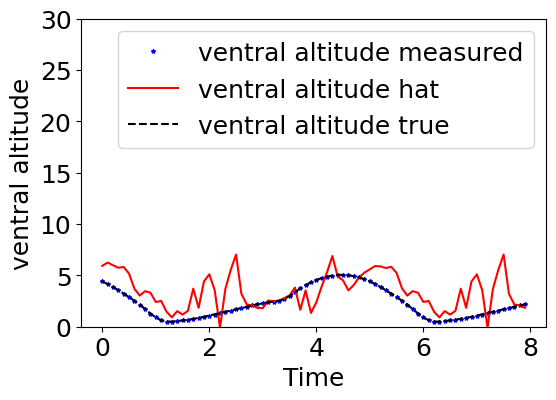

In [33]:
t_sim = np.arange(0, ray_estimate.shape[1]*0.1, 0.1)

ax = plot_tme(t_sim,
         ray_true_compressed_recon[105,:],
         ray_true[105,:],
         ray_estimate[105,:],
         label_var='ventral altitude',
         markersize=3)

ax.set_ylim(0, 30)

# 6.&nbsp;Exercises

1. **Test diverse trajectories:** Generate several different test trajectories with varying characteristics:
   - High-speed horizontal motion
   - Aggressive altitude changes
   - Hovering or slow motion
   
   How does the ANN performance vary with motion type?

2. **Test diverse terrain:** Create terrain profiles that differ significantly from the training set:
   - Flat terrain (low elevation variance)
   - Highly complex terrain (high elevation variance)
   - Terrain with periodic features (ridges, valleys)
   
   At what point does the estimator fail?

4. **Integration with filtering:** Put the estimates into an AI-KF (Artificial Intelligence Kalman Filter) framework. Use the compressed ray distance estimates as pseudo-measurements in a state estimation filter.